# Comparing the surface response for SciPy and PEST++ iES

In [1]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pastas as ps
import pyemu

import pastas_plugins.pest as psp

# Load Data

In [2]:
head = (
    pd.read_csv(
        "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/head_nb1.csv",
        index_col="date",
        parse_dates=True,
    ).squeeze()
).iloc[-300:]
prec = pd.read_csv(
    "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/rain_nb1.csv",
    index_col="date",
    parse_dates=True,
).squeeze()
evap = pd.read_csv(
    "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/evap_nb1.csv",
    index_col="date",
    parse_dates=True,
).squeeze()
pex = (prec - evap).dropna().rename("PrecipitationExcess")

In [3]:
pbounds = {
    "constant_d": {"initial": 27.5, "vary": False},
    "pex_A": {
        "pmin": 0.001,
        "pmax": 2500.0,
    },
    "pex_a": {
        "pmin": 0.01,
        "pmax": 1000.0,
    },
}

control_data = {
    "phiredstp": 1e-8,
    "nphistp": 25,
    "nphinored": 25,
    "relparstp": 1e-8,
}

# Create and solve model

## SciPy

TrackSolve feature under development. If you find any bugs please post an issue on GitHub: https://github.com/pastas/pastas/issues


Fit report head                   Fit Statistics
nfev    8                      EVP         88.64
nobs    300                    R2           0.89
noise   False                  RMSE         0.13
tmin    2001-05-28 00:00:00    AICc     -1231.89
tmax    2015-06-28 00:00:00    BIC      -1224.53
freq    D                      Obj          2.44
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (2 optimized)
               optimal     initial   vary
pex_A       866.230896  215.674528   True
pex_a       179.849683   10.000000   True
constant_d   27.500000   27.500000  False


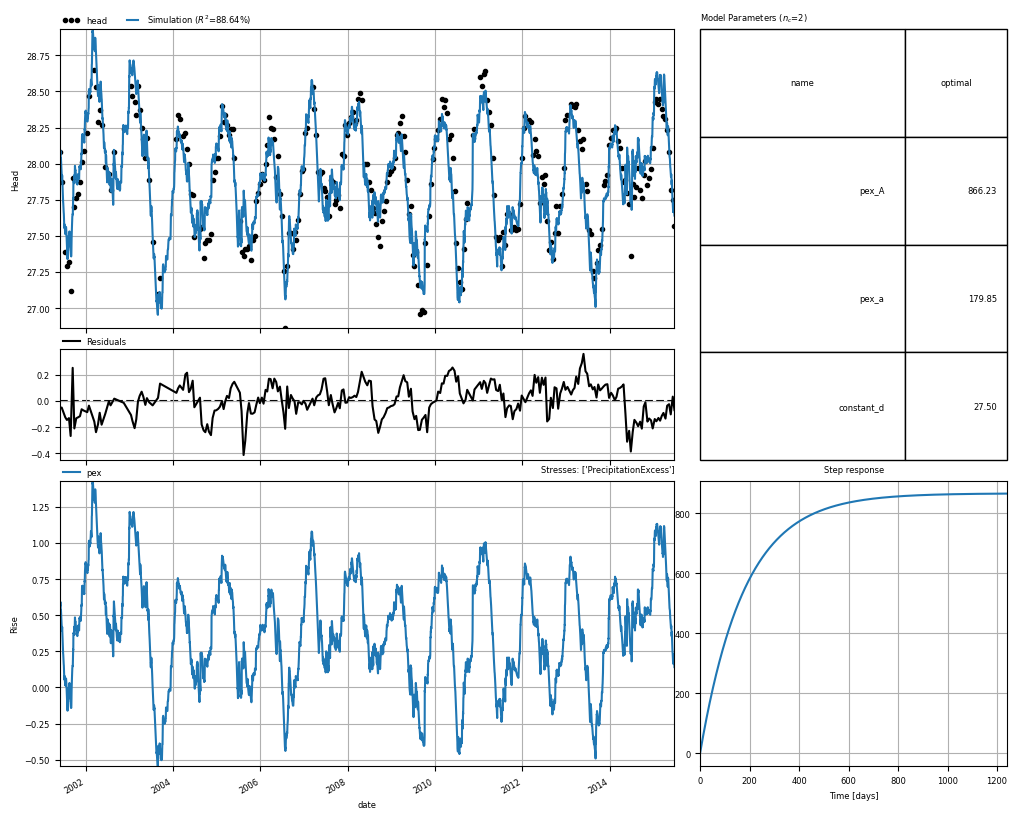

In [4]:
ml = ps.Model(head)
sm = ps.StressModel(
    pex, ps.Exponential(), name="pex", settings=ps.rcParams["timeseries"]["evap"]
)

ml.add_stressmodel(sm)
for pname, pvars in pbounds.items():
    ml.set_parameter(pname, **pvars)
tc = ps.TrackSolve(ml)
ml.solve(
    solver=ps.LeastSquares(),
    ftol=control_data["phiredstp"],
    xtol=control_data["relparstp"],
    callback=tc.track_solve,
)

axes = ml.plots.results()
f = axes[0].get_figure()

f.savefig("responsesurface_model.png", dpi=600, bbox_inches="tight")

## SciPy + AR(1)

In [5]:
ml_ar = ml.copy()
ml_ar.add_noisemodel(ps.ArNoiseModel())
for pname, pvars in pbounds.items():
    ml_ar.set_parameter(pname, **pvars)
tc_ar = ps.TrackSolve(ml_ar)
ml_ar.solve(
    solver=ps.LeastSquares(),
    ftol=control_data["phiredstp"],
    xtol=control_data["relparstp"],
    callback=tc_ar.track_solve,
)

TrackSolve feature under development. If you find any bugs please post an issue on GitHub: https://github.com/pastas/pastas/issues


Fit report head_copy              Fit Statistics
nfev    14                     EVP         88.58
nobs    300                    R2           0.89
noise   True                   RMSE         0.13
tmin    2001-05-28 00:00:00    AICc     -1473.60
tmax    2015-06-28 00:00:00    BIC      -1462.57
freq    D                      Obj          1.08
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (3 optimized)
                optimal     initial   vary
pex_A        870.983300  215.674528   True
pex_a        186.218405   10.000000   True
constant_d    27.500000   27.500000  False
noise_alpha   52.157531   14.000000   True


## PEST++ iES

In [17]:
ml_ies = ml.copy()
ml_ies.name = "PestIES"
solver = psp.PestIesSolver(
    exe_name="bin/pestpp-ies",
    model_ws=Path("pestf_ies/model"),
    temp_ws=Path("pestf_ies/temp"),
    master_ws=Path("pestf_ies/master"),
    noptmax=5,
    ies_num_reals=51,
    port_number=4004,
    control_data=control_data,
)
for pname, pvars in pbounds.items():
    ml_ies.set_parameter(pname, **pvars)
ml_ies.add_solver(solver)
ml_ies.solver.run_ensembles(
    ies_parameter_ensemble_method="truncnorm", observation_noise_standard_deviation=0.1
)

2024-09-17 13:04:21.547335 starting: opening PstFrom.log for logging
2024-09-17 13:04:21.547657 starting PstFrom process
2024-09-17 13:04:21.547738 starting: setting up dirs
2024-09-17 13:04:21.548366 starting: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/temp'
2024-09-17 13:04:21.550444 finished: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/temp' took: 0:00:00.002078
2024-09-17 13:04:21.550511 starting: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/temp'
2024-09-17 13:04:21.552063 finished: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/temp' took: 0:00:00.001552
2024-09-17 13:04:21.552527 finished: setting up dirs took: 0:00:00.004789
2024-09-17 13:04:21.581255 starting: adding grid type d style parameters for file(s) ['parameters_sel.

## PEST++ GLM

In [7]:
ml_glm = ml.copy()

solver = psp.PestGlmSolver(
    exe_name="bin/pestpp-glm",
    model_ws=Path("pestf_glm/model"),
    temp_ws=Path("pestf_glm/temp"),
    noptmax=250,
    control_data=control_data,
)
for pname, pvars in pbounds.items():
    ml_glm.set_parameter(pname, **pvars)
ml_glm.solve(solver=solver, report=False)

2024-09-17 12:44:58.976820 starting: opening PstFrom.log for logging
2024-09-17 12:44:58.977538 starting PstFrom process
2024-09-17 12:44:58.977705 starting: setting up dirs
2024-09-17 12:44:58.977858 starting: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/temp'
2024-09-17 12:44:58.986689 finished: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/temp' took: 0:00:00.008831
2024-09-17 12:44:58.986750 starting: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/temp'
2024-09-17 12:44:58.988553 finished: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/temp' took: 0:00:00.001803
2024-09-17 12:44:58.989808 finished: setting up dirs took: 0:00:00.012103
2024-09-17 12:44:59.021071 starting: adding grid type d style parameters for file(s) ['parameters_sel.

# Response surface

In [8]:
def obj_func(ml: ps.Model):
    """Objective function for the Pastas model."""
    observations = ml.observations()
    sim = ml.simulate()
    residuals = (observations - sim).dropna().values
    # res_diff = (observations.diff() - sim.diff()).dropna().values
    return np.sum(residuals**2)  # + np.sum(res_diff ** 2)


A_range = np.linspace(
    ml.parameters.at["pex_A", "pmin"], ml.parameters.at["pex_A", "pmax"], 100
)
a_range = np.linspace(
    ml.parameters.at["pex_a", "pmin"], ml.parameters.at["pex_a", "pmax"], 100
)

A_mg, a_mg = np.meshgrid(A_range, a_range)

ml_rs = ml.copy()
rsurface = np.zeros((len(a_range), len(A_range)))
for i, A in enumerate(A_range):
    for j, a in enumerate(a_range):
        ml_rs.set_parameter(name="pex_A", optimal=A)
        ml_rs.set_parameter(name="pex_a", optimal=a)
        rsurface[j, i] = obj_func(ml_rs)

In [9]:
def plot_response_surface():
    norm = mpl.colors.LogNorm(rsurface.min(), rsurface.max())
    cmap = mpl.cm.cividis
    scm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

    f, ax = plt.subplots(figsize=(6, 5))
    ax.pcolor(a_mg, A_mg, rsurface, norm=norm, cmap=cmap)
    ax.set_xlabel("a")
    ax.set_ylabel("A")
    f.colorbar(scm, ax=ax, label="Objective function")
    return ax

## SciPy LeastSquares trajectory

### Without AR(1) NoiseModel

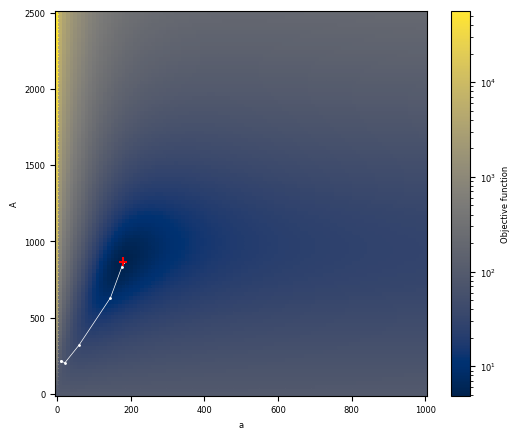

In [10]:
ax = plot_response_surface()
p_estimates = np.array(
    [[ml.parameters.loc["pex_A", "initial"], ml.parameters.loc["pex_a", "initial"]]]
    + list(tc.parameters.loc[:, ["pex_A", "pex_a"]].values[2::3])
)
ax.plot(
    p_estimates[:, 1],
    p_estimates[:, 0],
    color="white",
    marker=".",
    markersize=2.0,
    linewidth=0.5,
)
ax.errorbar(
    ml.parameters.loc["pex_a", "optimal"],
    ml.parameters.loc["pex_A", "optimal"],
    xerr=ml.parameters.loc["pex_a", "stderr"] * 2,
    yerr=ml.parameters.loc["pex_A", "stderr"] * 2,
    color="red",
)
ax.get_figure().savefig("responsesurface_scipy.png", dpi=600, bbox_inches="tight")

### With AR(1) NoiseModel

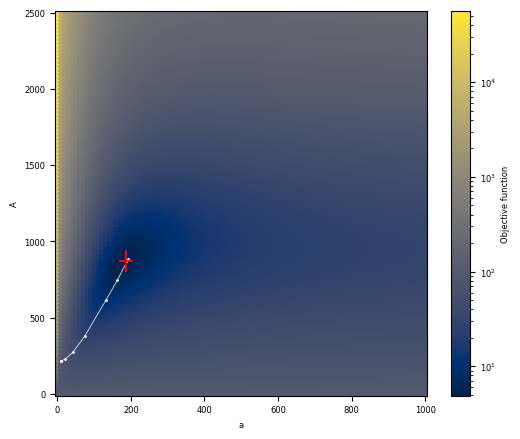

In [11]:
ax = plot_response_surface()
p_estimates = np.array(
    [
        [
            ml_ar.parameters.loc["pex_A", "initial"],
            ml_ar.parameters.loc["pex_a", "initial"],
        ]
    ]
    + list(tc_ar.parameters.loc[:, ["pex_A", "pex_a"]].values[3::4])
)
ax.plot(
    p_estimates[:, 1],
    p_estimates[:, 0],
    color="white",
    marker=".",
    markersize=2.0,
    linewidth=0.5,
)
ax.errorbar(
    ml_ar.parameters.loc["pex_a", "optimal"],
    ml_ar.parameters.loc["pex_A", "optimal"],
    xerr=ml_ar.parameters.loc["pex_a", "stderr"] * 2,
    yerr=ml_ar.parameters.loc["pex_A", "stderr"] * 2,
    color="red",
)
ax.get_figure().savefig("responsesurface_scipyar.png", dpi=600, bbox_inches="tight")

## PEST++ iES trajectory

In [18]:
par_csvs = sorted(ml_ies.solver.master_ws.glob("*.par.csv"))

par_dfs = []
for par_csv in par_csvs:
    par_df = pd.read_csv(par_csv, index_col=0)
    parv = ml_ies.parameters.vary
    par_df.columns = pd.MultiIndex.from_arrays(
        ([par_csv.stem.split(".")[1]] * sum(parv), ml_ies.parameters.index[parv])
    )
    par_dfs.append(par_df)
par_dfs = pd.concat(par_dfs, axis=1).stack(level=0)

ies_ci = par_dfs.loc[(slice(None), f"{ml_ies.solver.noptmax - 1}"), :].quantile(
    [0.025, 0.975], axis=0
)
ies_base = par_dfs.loc[("base", f"{ml_ies.solver.noptmax - 1}"), :]
ies_err = (ies_ci - ies_base).abs()

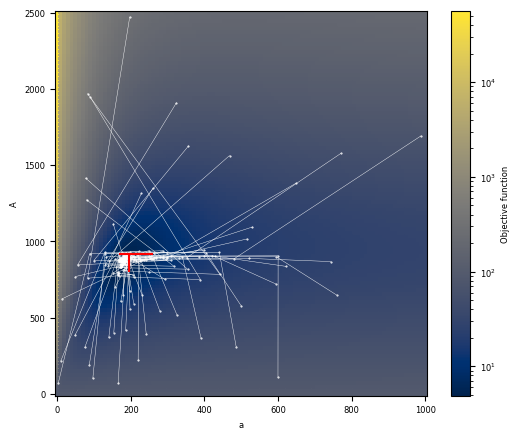

In [19]:
ax = plot_response_surface()
for idx in np.unique(par_dfs.index.get_level_values(0)):
    par_i = par_dfs.loc[idx, :]
    ax.plot(
        par_i.loc[:, "pex_a"],
        par_i.loc[:, "pex_A"],
        color="white",
        marker=".",
        markersize=1.0,
        linewidth=0.3,
    )
ax.errorbar(
    ies_base.at["pex_a"],
    ies_base.at["pex_A"],
    xerr=ies_err.loc[:, ["pex_a"]].values,
    yerr=ies_err.loc[:, ["pex_A"]].values,
    color="red",
)
ax.get_figure().savefig("responsesurface_ies.png", dpi=600, bbox_inches="tight")

## PEST++ GLM trajectory

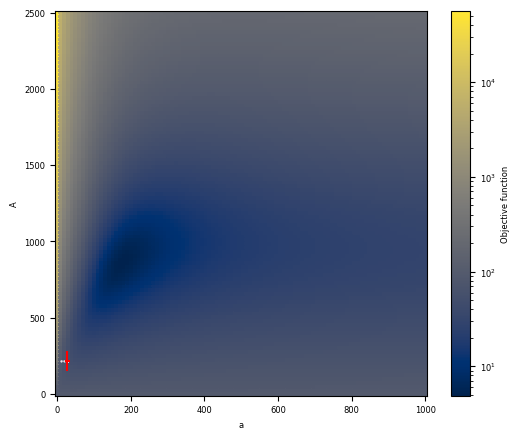

In [14]:
par_usum = pd.read_csv(
    ml_glm.solver.temp_ws / "pest.par.usum.csv", index_col=0
).set_index(ml_glm.parameters.index[ml_glm.parameters.vary])
ipar = (
    pd.read_csv(ml_glm.solver.temp_ws / "pest.ipar", index_col=0)
    .transpose()
    .set_index(ml_glm.parameters.index[ml_glm.parameters.vary])
    .transpose()
)

ax = plot_response_surface()
ax.plot(
    ipar.loc[:, "pex_a"],
    ipar.loc[:, "pex_A"],
    color="white",
    marker=".",
    markersize=1.0,
    linewidth=0.3,
)
ax.errorbar(
    par_usum.at["pex_a", "post_mean"],
    par_usum.at["pex_A", "post_mean"],
    xerr=par_usum.at["pex_a", "post_stdev"] * 2,
    yerr=par_usum.at["pex_A", "post_stdev"] * 2,
    color="red",
)
ax.get_figure().savefig("responsesurface_glm.png", dpi=600, bbox_inches="tight")

# Jacobian

In [52]:
jac_ls = pd.DataFrame(
    ml.solver.result.jac,
    index=ml.observations().index,
    columns=ml.parameters.index[ml.parameters.vary],
)
jac_ar = pd.DataFrame(
    ml_ar.solver.result.jac,
    index=ml_ar.observations().index,
    columns=ml_ar.parameters.index[ml_ar.parameters.vary],
)
jac_glm = (
    pyemu.Jco.from_binary(ml_glm.solver.temp_ws / "pest.jcb")
    .df()
    .transpose()
    .set_index(ml_glm.parameters.index[ml_glm.parameters.vary])
    .transpose()
)
jac_ies = ml_ies.solver.jacobian(iteration=ml_ies.solver.nfev)

return type uncaught, losing Ensemble type, returning DataFrame
return type uncaught, losing Ensemble type, returning DataFrame


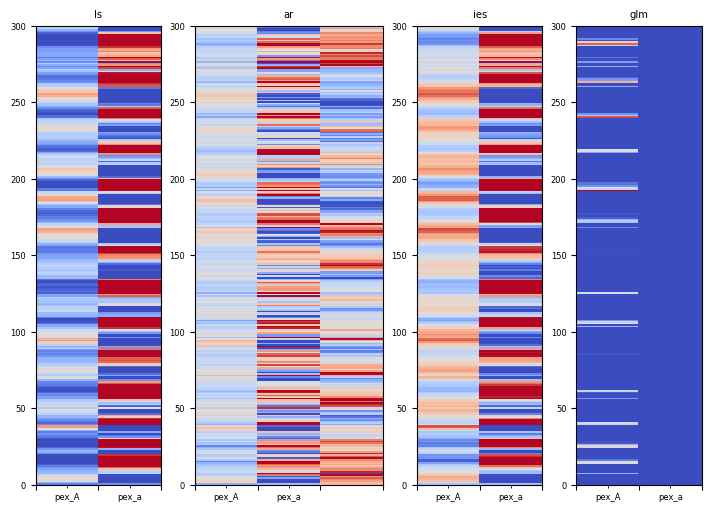

In [53]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=-1e-3, vmax=1e-3)

f, axd = plt.subplot_mosaic(
    [["ls", "ar", "ies", "glm"]],
    figsize=(7, 5),
    constrained_layout=True,
    width_ratios=[2, 3, 2, 2],
)
axd["ls"].pcolor(jac_ls, cmap=cmap, norm=norm)
axd["ar"].pcolor(jac_ar, cmap=cmap, norm=norm)
axd["ies"].pcolor(jac_ies, cmap=cmap, norm=norm)
axd["glm"].pcolor(jac_glm.values, cmap=cmap, norm=norm)

for k in axd:
    axd[k].set_title(k)
    axd[k].xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    axd[k].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    axd[k].set_xticklabels([], minor=False)
    axd[k].set_xticks(np.arange(len(jac_glm.columns)) + 0.5, minor=True)
    axd[k].set_xticklabels([x for x in jac_glm.columns], minor=True)